In [27]:
from PIL import Image
import jax
from jax import random
import jax.numpy as jnp
import flaxmodels as fm
from torchvision import datasets, models, transforms
import torchvision
import torch
import matplotlib.pyplot as plt
from flax import traverse_util
import flax
import flax.linen as nn
from flax.core.frozen_dict import freeze
from optax import adamw
from flax.core.frozen_dict import FrozenDict
from flax.core import frozen_dict
import optax
from functools import partial
import os

key = random.PRNGKey(0)

In [2]:
# Load image
img = Image.open('data/n01440764_tench.JPEG')
# Image must be 224x224 if classification head is included
img = img.resize((224, 224))
# Image should be in range [0, 1]
x = jnp.array(img, dtype=jnp.float32) / 255.0
# Add batch dimension
x = jnp.expand_dims(x, axis=0)

In [3]:
x.shape

(1, 224, 224, 3)

In [4]:
resnet18 = fm.ResNet18(output='activations', pretrained='imagenet')
# params = vgg16.init(key, x)
# out = vgg16.apply(params, x, train=False)

In [5]:
vgg19 = fm.VGG19(output='activations', pretrained='imagenet')
params = vgg19.init(key, x, train=False)

Downloading: "https://www.dropbox.com/s/1sn02fnkj579u1w/vgg19_weights.h5" to /var/folders/_0/jg31z24j4s78_r7b93bhvd400000gn/T/flaxmodels/vgg19_weights.h5


100%|██████████| 575M/575M [04:32<00:00, 2.11MiB/s]  


In [6]:
rng_image = random.uniform(key, shape=(1, 224, 224, 3))

In [7]:
# params = resnet18.init(key, rng_image)


In [8]:
# out = resnet18.apply(params, rng_image, train=False)
out = vgg19.apply(params, rng_image, train=False)
out.keys()

dict_keys(['conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3', 'relu3_3', 'conv3_4', 'relu3_4', 'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3', 'relu4_3', 'conv4_4', 'relu4_4', 'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3', 'relu5_3', 'conv5_4', 'relu5_4', 'fc6', 'relu6', 'fc7', 'relu7', 'fc8'])

In [9]:
out['fc8'].shape

(1, 1000)

In [10]:
out['fc8'][0, 0]

DeviceArray(0.6761138, dtype=float32)

In [11]:
out['conv5_2'][0, :, :, 0].shape

(14, 14)

In [12]:
out['conv1'].shape

KeyError: 'conv1'

In [13]:
cnn_layer = 0
cnn_filter = 0

In [ ]:
out['block1_0'][0, :, :, 2].shape

(56, 56)

In [ ]:
out.keys()

dict_keys(['conv1', 'block1_0', 'block1_1', 'block2_0', 'block2_1', 'block3_0', 'block3_1', 'block4_0', 'block4_1', 'fc'])

In [ ]:
out['block1_0'].shape

(1, 56, 56, 64)

In [ ]:
jnp.mean(out['conv1'][0, :, :, 0])  

DeviceArray(0.02512577, dtype=float32)

In [56]:
def str_tree(d, depth, print_value=False):
    s = ""
    for k in d.keys():
        if isinstance(d[k], FrozenDict):
            s += f'{"  " * depth} {k}\n'
            s += str_tree(d[k], depth + 1, print_value)
        else:
            s += f'{"  " * depth} {k} {d[k].shape}\n'
    return s


In [57]:
print(print_tree(variables, 3))

       params
         ImageLayer_0
           image (1, 224, 224, 3)
         backbone
           conv1_1
             kernel (3, 3, 3, 64)
             bias (64,)
           conv1_2
             kernel (3, 3, 64, 64)
             bias (64,)
           conv2_1
             kernel (3, 3, 64, 128)
             bias (128,)
           conv2_2
             kernel (3, 3, 128, 128)
             bias (128,)
           conv3_1
             kernel (3, 3, 128, 256)
             bias (256,)
           conv3_2
             kernel (3, 3, 256, 256)
             bias (256,)
           conv3_3
             kernel (3, 3, 256, 256)
             bias (256,)
           conv3_4
             kernel (3, 3, 256, 256)
             bias (256,)
           conv4_1
             kernel (3, 3, 256, 512)
             bias (512,)
           conv4_2
             kernel (3, 3, 512, 512)
             bias (512,)
           conv4_3
             kernel (3, 3, 512, 512)
             bias (512,)
           conv4_4
          

In [15]:
def revert_image(image):
    image = image.squeeze(0)

    return image

In [16]:
def save_image(img, path):
    """Displays and saves the processsed image from the
    given layer/filter number.
    Arguments:
        - image (np.ndarray)
        - path (string) save path
    """
    plt.figure(figsize=[2, 2])
    plt.imshow(img)
    plt.axis("off")
    plt.tight_layout(pad=0.5, h_pad=0, w_pad=0)
    plt.savefig(path, dpi=150)
    plt.show()


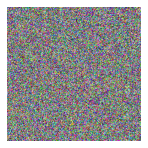

In [17]:
r_image = revert_image(rng_image)
save_image(r_image, 'output/tmp.png')

In [18]:
@jax.jit
def train_step(state, batch, layer_name, filter_num):
    def loss_fn(params):
        act = state.apply_fn({'params': params}, batch)
        act = act[layer_name][0, :, :, filter_num]

        loss = - jnp.mean(act)
        return loss

    grads = jax.grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads)

In [19]:
im_params = {
    'params': rng_image.squeeze(0)
}

In [20]:
class ImageLayer(nn.Module):
    @nn.compact
    def __call__(self, inputs):
        kernel = self.param("image", jax.nn.initializers.constant(1), (1, 224, 224, 3))
        return jax.lax.mul(inputs, kernel)


In [21]:
class ModelWrapper(nn.Module):
    backbone: nn.Module

    @nn.compact
    def __call__(self, x):
        x = ImageLayer()(x)

        x = self.backbone(x, train=False)
        return x

In [22]:
# model = Tmp(fm.ResNet18(output='activations', pretrained='imagenet'))
model = ModelWrapper(fm.VGG19(output='activations', pretrained='imagenet'))
variables = model.init(jax.random.PRNGKey(1), rng_image)
variables = variables.unfreeze()
variables['params']['backbone'] = params['params']
variables = freeze(variables)

In [23]:
def create_mask():
    mask = {'params': {'ImageLayer_0': 'ImageLayer_0', 'backbone': 'backbone'}}
    return frozen_dict.freeze(mask)

def zero_grads():
    def init_fn(_): 
        return ()
    def update_fn(updates, state, params=None):
        return jax.tree_map(jnp.zeros_like, updates), ()
    return optax.GradientTransformation(init_fn, update_fn)

In [32]:
@partial(
    jax.jit,
    static_argnums=(
        2,
        3,
    ),
)
def train_step(params, img, layer_name, filter_num):
    def loss_fn(params):
        act = model.apply(params, img)
        if "fc" in layer_name:
            act = act[layer_name][:, int(filter_num)]
        else:
            act = act[layer_name][0, :, :, int(filter_num)]

        loss = -jnp.mean(act)
        return loss

    loss_val, grad_val = jax.value_and_grad(loss_fn)(params)

    return loss_val, grad_val["params"]["ImageLayer_0"]["image"]


step: 4 loss: -8.171562194824219
step: 9 loss: -22.903026580810547


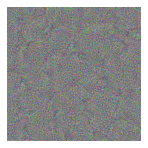

step: 14 loss: -38.83122253417969
step: 19 loss: -56.607017517089844


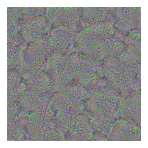

step: 24 loss: -76.25276184082031
step: 29 loss: -97.39134216308594


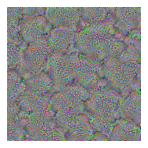

step: 34 loss: -119.3165054321289


step: 39 loss: -140.925048828125


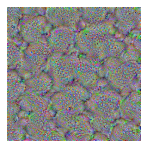

step: 44 loss: -162.3262939453125


step: 49 loss: -183.2373809814453


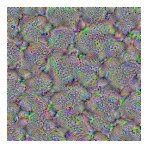

step: 54 loss: -203.30665588378906


step: 59 loss: -222.55770874023438


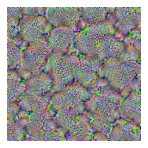

step: 64 loss: -241.16448974609375


step: 69 loss: -259.1026916503906


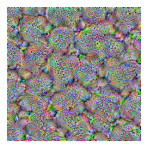

step: 74 loss: -276.6325988769531


step: 79 loss: -293.7891845703125


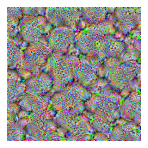

step: 84 loss: -310.621826171875


step: 89 loss: -327.283203125


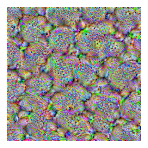

step: 94 loss: -343.7456359863281


step: 99 loss: -360.0986022949219


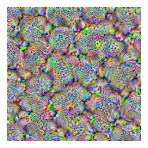

In [33]:
layer_name = "conv5_2"
filter_num = "0"
model_name = "vgg16"

output_path = f"output/{model_name}/{layer_name}/{filter_num}"
os.makedirs(output_path, exist_ok=True)

steps = 100
lr = 0.01
optimizer = adamw(lr, weight_decay=1e-6)

rng_image = random.randint(key, shape=(1, 224, 224, 3), minval=83, maxval=171)
rng_image = rng_image.astype(jnp.float32)
rng_image = rng_image / 255

opt_state = optimizer.init({"params": rng_image})

for step in range(steps+1):
    loss, grad = train_step(variables, rng_image, layer_name, filter_num)
    updates, opt_state = optimizer.update(
        {"params": grad}, opt_state, {"params": rng_image}
    )
    rng_image = optax.apply_updates({"params": rng_image}, updates)
    rng_image = rng_image["params"]

    if (step) % 5 == 0:
        print(f"step: {step} loss: {loss}")

    if (step) % 10 == 0:
        r_image = revert_image(rng_image)
        save_image(r_image, f"{output_path}/{step}.png")
